# Experiments Notebook 1


In [22]:
import os
import os.path
import pickle
import bz2
from glob import glob
import random
import shutil
import pathlib
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [2]:
import preprocessing as pp

In [3]:
from tqdm.auto import tqdm

In [4]:
pd.set_option("display.max_columns", None)

### Load the golden data

In [5]:
# Windows version
golden_dataset_file_name = os.path.join('..', '..', 'data', 'golden', 'feeFiFoFum.pbz2')

# data = bz2.BZ2File(golden_dataset_file_name,'rb')
with bz2.BZ2File(golden_dataset_file_name,'rb') as data:
    df = pd.read_pickle(data)


### Clean up the data

#### Drop non-numeric and unnecessary columns

In [6]:
cols = ['NYT_ConfirmedCases.data','NYT_ConfirmedDeaths.data','NYT_ConfirmedDeaths.missing','county','LND110210','countyStateName','stateFip','countyFip']

df.drop(cols, axis=1, inplace=True)

#### Temporarily, replace FIPS codes with latitude and longitude of the centroid of each county

In [7]:
counties = pd.read_csv('../noah/2021_Gaz_counties_national.txt', delimiter='\t')
counties.rename(columns={'INTPTLONG                                                                                                               ': 'INTPTLONG'}, inplace=True)

counties = counties[['GEOID', 'INTPTLAT', 'INTPTLONG' ]]
df.fips = df.fips.astype('int64')

df = df.merge(counties, how='left', left_on='fips', right_on='GEOID')
df.drop(['GEOID'], axis=1, inplace=True)

In [8]:
crossed_latlong = pp.get_latlong_fc(df)

In [9]:
# the 9 here is the dimensions parameter in the embedding_column function. It appears to be another hyperparameter.
embedded_latlong = tf.feature_column.embedding_column(crossed_latlong,dimension=9)

In [10]:
feature_layer = tf.keras.layers.DenseFeatures(embedded_latlong)

#### Replace dates with monotonically increasing integers starting with the minimum date

In [11]:
df.dates = pd.to_datetime(df.dates, format='%Y-%m-%d')
min_date = min(df.dates)
max_date = max(df.dates)
min_date, max_date, df.dates.dtype

(Timestamp('2020-03-11 00:00:00'),
 Timestamp('2022-01-16 00:00:00'),
 dtype('<M8[ns]'))

In [12]:
df['day'] =(df.dates - min_date).dt.days
df.drop(['dates'], axis=1, inplace=True)

#### Replace the integer representation of date with sin and cosine encoding

In [13]:
cyclical_interval = 365
continuous_interval = 3650
df['cyclical_sin'] = np.sin((df.day * 2 * np.pi)/cyclical_interval)
df['cyclical_cos'] = np.cos((df.day * 2 * np.pi)/cyclical_interval)
df['continuous_sin'] = np.sin((df.day * 2 * np.pi)/continuous_interval)
df['continuous_cos'] = np.cos((df.day * 2 * np.pi)/continuous_interval)
df.drop('day', axis=1, inplace=True)

#### Normalize the data

In [14]:
cols_to_normalize = [
       'TotalPopulation.data', 'MaleAndFemale_AtLeast65_Population.data',
       'Male_Total_Population.data', 'Female_Total_Population.data',
       'MaleAndFemale_Under18_Population.data', 'BLS_EmployedPopulation.data',
       'BLS_EmployedPopulation.missing', 'BLS_UnemployedPopulation.data',
       'BLS_UnemployedPopulation.missing', 'BLS_UnemploymentRate.data',
       'BLS_UnemploymentRate.missing', 'BLS_LaborForcePopulation.data',
       'BLS_LaborForcePopulation.missing', 'AverageDailyTemperature.data',
       'AverageDailyTemperature.missing', 'AverageDewPoint.data',
       'AverageDewPoint.missing', 'AverageRelativeHumidity.data',
       'AverageRelativeHumidity.missing', 'AverageSurfaceAirPressure.data',
       'AverageSurfaceAirPressure.missing', 'AveragePrecipitationTotal.data',
       'AveragePrecipitationTotal.missing', 'AveragePrecipitation.data',
       'AveragePrecipitation.missing', 'AverageWindDirection.data',
       'AverageWindDirection.missing', 'AverageWindSpeed.data',
       'AverageWindSpeed.missing', 'hospitalIcuBeds', 'hospitalStaffedBeds',
       'hospitalLicensedBeds', 'latestTotalPopulation', 'jhu_daily_death',
       'jhu_daily_cases', 'jhu_daily_new_cases', 
    'jhu_daily_death_rolling_7',
       'jhu_daily_cases_rolling_7', 'jhu_daily_new_cases_rolling_7',
       'jhu_daily_death_rolling_30', 'jhu_daily_cases_rolling_30',
       'jhu_daily_new_cases_rolling_30', 'jhu_death_rate', 'jhu_case_rate',
       'jhu_new_case_rate', 'density', 'icu_beds_per_person',
       'staffed_beds_per_person', 'licensed_beds_per_person', 'cold_days',
       'hot_days', 'moderate_days', 'gte_65_percent', 'lt_18_percent',
       'employed_percent', 'unemployed_percent', 'totalMoved',
       'movedWithinState', 'movedWithoutState', 'movedFromAbroad',
       'publicTrans', 'totalTrans', 'householdsTotal', 'houseWith65',
       'house2+with65', 'houseFamily65', 'houseNonfam65', 'houseNo65',
       'house2+No65', 'houseFamilyNo65', 'houseNonfamNo65',
       'householdStructuresTotal', 'householdIncomeMedian', 'gini',
       'hoursWorkedMean', 'unitsInStructure', 'healthInsTotal',
       'healthInsNativeWith', 'healthInsForeignNatWith',
       'healthInsForeignNoncitWith', 'healthInsForeignNatNo',
       'healthInsForeignNoncitNo', 'healthInsNativeNo', 'pm25']
cols_raw = ['fips','JHU_ConfirmedCases.data', 'JHU_ConfirmedDeaths.data', 'cyclical_sin', 'cyclical_cos', 'continuous_sin',
       'continuous_cos', 'latitude','longitude']
df_normalized = df[cols_to_normalize]
df_normalized = (df_normalized - df_normalized.mean())/df_normalized.std()
df_raw = df[cols_raw]
df = pd.concat([df_raw, df_normalized], axis=1)


#### Prepare the data for training

In [15]:
days_of_history = 30
days_to_predict = 1

In [16]:
fips = df.fips.unique()

def x_generator(data, days_of_history=30, days_to_predict=1):
    for j, fip in enumerate(fips):
        if not j % 100: print(j, end=' ')
        county = data[data.fips == fip]
        for i in range(days_of_history, len(county) - days_to_predict):
            data_matrix = data.iloc[i - days_of_history: i, 1:].to_numpy()
            yield data_matrix
            
def y_generator(data, days_of_history=30, days_to_predict=1):
    for fip in fips:
        county = data[data.fips == fip]
        for i in range(days_of_history, len(county) - days_to_predict):
            data_matrix = data.iloc[i: i + days_to_predict, 1:3].to_numpy()
            yield data_matrix
    
def xy_generator(data, days=31):
    for j, fip in enumerate(fips):
        if not j % 100: print(j, end=' ')
        county = data[data.fips == fip]
        for i in range(days, len(county) + 1):
            data_matrix = data.iloc[i - days: i, 1:].to_numpy()
            yield data_matrix
            
        
            
    

##### Save the raw X and Y to files of 50,000 sequences

In [44]:
Xi = []
j = 0

N_SAMPLES = 200

for i, x in tqdm(enumerate(xy_generator(df))):
    Xi.append(x)
    if i and not i % (N_SAMPLES - 1):
        X = np.asarray(Xi)
        np.savez(os.path.join('.','data', f'x_{j}.npz'), X)
        j += 1
        Xi = []
    
if Xi:
    X = np.asarray(Xi)
    np.savez(os.path.join('.','data', f'x_{j}.npz'), X)
 



0it [00:00, ?it/s]

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 

##### Split into train, test, eval directories

In [45]:
pathlib.Path.cwd()

WindowsPath('F:/projects/Drexel/DS-capstone-pt1/experiments/avk')

In [ ]:
tfdata_dir = pathlib.Path.cwd().joinpath("..","noah","data")

In [50]:
x_files = glob('./data/x_*.npz')
random.shuffle(x_files)
n_files = len(x_files)
print(n_files)
n_train = int(n_files * 0.70)
print(n_train)
n_eval = int(n_files * 0.15)
print(n_eval)
n_test = n_files - n_train - n_eval
print(n_test)
train_files = x_files[:n_train]
# print(len(train_files))
eval_files = x_files[n_train:n_train+n_test]
# print(len(eval_files))
test_files = x_files[n_train+n_test:]
assert n_files == len(train_files) + len(eval_files) + len(test_files)
for (subdir, lst) in [['train', train_files], ['eval', eval_files], ['test', test_files]]:
    for file in lst:
        shutil.move(file, os.path.join('.', 'data', subdir))
        

8983
6288
1347
1348


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: './data\\x_11685.npz'

##### Create the Tensorflow Dataset

In [17]:


train_files = glob('./data/train/x_*.npz')
eval_files = glob('./data/eval/x_*.npz')
test_files = glob('./data/test/x_*.npz')

n_readers = 5
n_parse_threads = 5
len_array = 995

def create_generator(files, cycle_length=5):
    random.shuffle(files)
    for i in range(0, len(files), cycle_length):
        subset = files[i:i+cycle_length]
        np_arrays = [np.load(s)['arr_0'] for s in subset]
        np_array = np.concatenate(np_arrays, axis=0)
        if np_array.shape[0] != len_array:
            continue
        np.random.shuffle(np_array)
        yield np_array        
            

def split_xy(np_array):
    # seq_len = np_array.shape[1]
    X = np_array[:,:-1,:]
    y = np_array[:,-1:,:1]
    return X,y
        
    
def get_dataset_size():
    size = 0
    for file in x_files:
        x = np.load(file)['arr_0']
        if x.shape[0] != 199:
            continue
        # print(x.shape)
        # break
        size += x.shape[0]
    return size


def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000, seed=None):
    """ Adapted from https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438"""
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=seed)
    
    train_size = int(train_split * ds_size)
    print('Train size:', train_size)
    val_size = int(val_split * ds_size)
    print('Val size:', val_size)
    print('Test size:', ds_size - train_size - val_size)
    
    BATCH_SIZE = 4096
    train_ds = ds.take(train_size).prefetch(1)    
    val_ds = ds.skip(train_size).take(val_size).prefetch(1)
    test_ds = ds.skip(train_size).skip(val_size).prefetch(1)
    
    return train_ds, val_ds, test_ds    
    
    
train_ds = tf.data.Dataset.from_generator(lambda: create_generator(train_files, cycle_length=n_readers), output_types=tf.float32 )
train_ds = train_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

val_ds = tf.data.Dataset.from_generator(lambda: create_generator(eval_files, cycle_length=n_readers), output_types=tf.float32 )
val_ds = val_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

test_ds = tf.data.Dataset.from_generator(lambda: create_generator(test_files, cycle_length=n_readers), output_types=tf.float32 )
test_ds = test_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

In [18]:
import sys

In [20]:
dataset = tf.data.Dataset.from_generator(lambda: create_generator(x_files, cycle_length=n_readers), output_types=tf.float32 )

i = 0
for x in val_ds:
    print(x.shape)
    break
    i += 1
    if not i % 100_000:
        print(i, end=' ')
print(i)

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
sys.getsizeof(train_ds)

In [ ]:
help( dataset)

In [52]:
count = 0
for line in val_ds.take(100):
    X, y = line
    print('X shape:', X.shape)
    
    # print('X:', X)
    print('y shape:', y.shape)
    # print('y:', y)
    if count >= 10:
        break


X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: (995, 1, 1)
X shape: (995, 30, 92)
y shape: 

KeyboardInterrupt: 

## Building the model

In [53]:

feature_layer_outputs = feature_layer(feature_layer_inputs)
# model = keras.Model(inputs=[v for v in feature_layer_inputs.values()], outputs=baggage_pred)
tin =[v for v in feature_layer_inputs.values()]

NameError: name 'feature_layer_inputs' is not defined

In [36]:
input = keras.layers.Input(shape=(30,92))
lstm1 = keras.layers.LSTM(512, return_sequences=True)(input)
dropout1 = keras.layers.Dropout(0.20)(lstm1)
lstm2 = keras.layers.LSTM(512, return_sequences=True)(dropout1)
dropout2 = keras.layers.Dropout(0.20)(lstm2)
lstm3 = keras.layers.LSTM(512, return_sequences=True)(dropout2)
dropout3 = keras.layers.Dropout(0.20)(lstm3)
lstm4 = keras.layers.LSTM(512, return_sequences=True)(dropout3)
dropout4 = keras.layers.Dropout(0.20)(lstm4)
lstm5 = keras.layers.LSTM(512)(dropout4)
output = keras.layers.Dense(1)(lstm5)
model = keras.models.Model(inputs=input, outputs=output)

In [44]:
# Simple model for quick testing

input = keras.layers.Input(shape=(30,92))
lstm1 = keras.layers.LSTM(32, return_sequences=True)(input)
output = keras.layers.Dense(1)(lstm1)
model = keras.models.Model(inputs=input, outputs=output)

In [ ]:
model.summary()

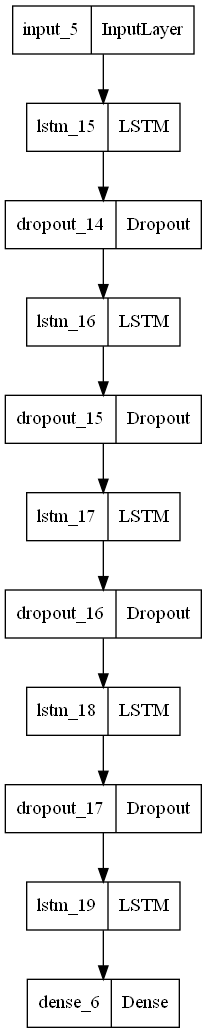

In [37]:
# keras.utils.plot_model(model, to_file='multilayer_perceptron_graph.png')
keras.utils.plot_model(model)


In [ ]:
seq_len = days_of_history
future_predict = days_to_predict
NAME = f"{seq_len}-SEQ-{future_predict}-PRED-{int(time.time())}"#unique name for each model

# setting the optimizer parameters
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer = opt,  loss='mae',  metrics=['mse', 'mae'])
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(NAME))

checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/model/covid_lstm.h5', save_best_only=True)


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=10, restore_best_weights=True)
history = model.fit(train_ds, epochs=32, 
                    validation_data=val_ds, 
                    callbacks=[tensorboard, checkpoint_cb, early_stopping_cb]
                   )

# building sequential model bc keras vs tf is a pain atm

In [19]:
%load_ext tensorboard

In [54]:
model = keras.Sequential([
    # feature_layer,
    embedded_latlong,
    # keras.layers.Input(shape=(30,92)),
    keras.layers.LSTM(128,input_shape=(30,92),return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
    ])

TypeError: The added layer must be an instance of class Layer. Received: layer=EmbeddingColumn(categorical_column=CrossedColumn(keys=(BucketizedColumn(source_column=NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(25.58612, 25.821034474747474, 26.05594894949495, 26.290863424242424, 26.5257778989899, 26.760692373737374, 26.99560684848485, 27.230521323232324, 27.4654357979798, 27.700350272727274, 27.935264747474747, 28.170179222222224, 28.405093696969697, 28.640008171717174, 28.874922646464647, 29.109837121212124, 29.344751595959597, 29.57966607070707, 29.814580545454547, 30.04949502020202, 30.284409494949497, 30.51932396969697, 30.754238444444447, 30.98915291919192, 31.224067393939393, 31.45898186868687, 31.693896343434346, 31.92881081818182, 32.16372529292929, 32.39863976767677, 32.63355424242424, 32.868468717171716, 33.10338319191919, 33.33829766666667, 33.573212141414146, 33.808126616161616, 34.04304109090909, 34.27795556565657, 34.51287004040404, 34.747784515151515, 34.98269898989899, 35.21761346464646, 35.45252793939394, 35.687442414141415, 35.922356888888885, 36.15727136363636, 36.39218583838384, 36.627100313131315, 36.86201478787879, 37.09692926262626, 37.33184373737374, 37.566758212121215, 37.801672686868685, 38.03658716161616, 38.27150163636364, 38.50641611111111, 38.741330585858584, 38.97624506060606, 39.21115953535354, 39.446074010101015, 39.680988484848484, 39.91590295959596, 40.15081743434344, 40.38573190909091, 40.620646383838384, 40.85556085858586, 41.09047533333333, 41.32538980808081, 41.560304282828284, 41.79521875757575, 42.03013323232324, 42.26504770707071, 42.499962181818184, 42.73487665656566, 42.96979113131313, 43.20470560606061, 43.43962008080808, 43.67453455555555, 43.90944903030303, 44.14436350505051, 44.379277979797976, 44.61419245454545, 44.84910692929293, 45.0840214040404, 45.31893587878788, 45.55385035353535, 45.78876482828283, 46.023679303030306, 46.258593777777776, 46.49350825252525, 46.72842272727273, 46.9633372020202, 47.198251676767676, 47.43316615151515, 47.66808062626262, 47.902995101010106, 48.137909575757575, 48.372824050505045, 48.60773852525253, 48.842653)), BucketizedColumn(source_column=NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-124.210929, -123.6391959191919, -123.06746283838383, -122.49572975757575, -121.92399667676767, -121.35226359595958, -120.78053051515151, -120.20879743434342, -119.63706435353535, -119.06533127272726, -118.49359819191919, -117.9218651111111, -117.35013203030303, -116.77839894949494, -116.20666586868685, -115.63493278787878, -115.0631997070707, -114.49146662626262, -113.91973354545453, -113.34800046464646, -112.77626738383837, -112.2045343030303, -111.63280122222221, -111.06106814141414, -110.48933506060605, -109.91760197979798, -109.34586889898989, -108.7741358181818, -108.20240273737373, -107.63066965656564, -107.05893657575757, -106.48720349494948, -105.91547041414141, -105.34373733333332, -104.77200425252525, -104.20027117171716, -103.62853809090907, -103.056805010101, -102.48507192929293, -101.91333884848484, -101.34160576767675, -100.76987268686868, -100.1981396060606, -99.62640652525252, -99.05467344444443, -98.48294036363636, -97.91120728282827, -97.3394742020202, -96.76774112121211, -96.19600804040402, -95.62427495959595, -95.05254187878788, -94.48080879797979, -93.9090757171717, -93.33734263636363, -92.76560955555554, -92.19387647474747, -91.62214339393938, -91.0504103131313, -90.47867723232322, -89.90694415151515, -89.33521107070706, -88.76347798989897, -88.1917449090909, -87.62001182828283, -87.04827874747474, -86.47654566666665, -85.90481258585858, -85.3330795050505, -84.76134642424242, -84.18961334343433, -83.61788026262624, -83.04614718181817, -82.4744141010101, -81.90268102020201, -81.33094793939392, -80.75921485858585, -80.18748177777778, -79.61574869696969, -79.0440156161616, -78.47228253535353, -77.90054945454546, -77.32881637373737, -76.75708329292928, -76.1853502121212, -75.61361713131312, -75.04188405050505, -74.47015096969696, -73.89841788888887, -73.3266848080808, -72.75495172727273, -72.18321864646464, -71.61148556565655, -71.03975248484848, -70.4680194040404, -69.89628632323232, -69.32455324242423, -68.75282016161614, -68.18108708080807, -67.609354))), hash_bucket_size=1000, hash_key=None), dimension=9, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x0000023B48EBEF70>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True) of type <class 'tensorflow.python.feature_column.feature_column_v2.EmbeddingColumn'>.

In [50]:
seq_len = days_of_history
future_predict = days_to_predict
NAME = f"{seq_len}-SEQ-{future_predict}-PRED-{int(time.time())}"#unique name for each model
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/{}".format(NAME))
checkpoint_cb = keras.callbacks.ModelCheckpoint('./data/model/covid_lstm{}.h5'.format(NAME), save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=10, restore_best_weights=True)

model.compile(optimizer = 'adam',  loss='mae',  metrics=['mse', 'mae'])



In [51]:
history = model.fit(train_ds, epochs=32, 
                    validation_data=val_ds, 
                    callbacks=[tensorboard, checkpoint_cb, early_stopping_cb]
                   )

Epoch 1/32


ValueError: in user code:

    File "F:\projects\venvs\capDL\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "F:\projects\venvs\capDL\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "F:\projects\venvs\capDL\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "F:\projects\venvs\capDL\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "F:\projects\venvs\capDL\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "sequential_8" (type Sequential).
    
    Cannot iterate over a shape with unknown rank.
    
    Call arguments received:
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • training=True
      • mask=None


In [ ]:
# I added this to the data preprocessing, so not required

class TimeEncoding(keras.layers.Layer):
    """ Layer to encode cyclical and continuous time.  
    Input should an n x 1 array or vector of integers.  
    Integers represent number of time units (i.e., days) from the starting point"""

    def __init__(self, cyclical_interval=365, continuous_interval=3650 , **kwargs):
        self.cyclical_interval = cyclical_interval
        self.continuous_interval = continuous_interval
        super(TimeEncoding, self).__init__(**kwargs)

    def call(self, x):
        
        cyclical_sin = np.sin((x * 2 * np.pi)/self.cyclical_interval)
        cyclical_cos = np.cos((x * 2 * np.pi)/self.cyclical_interval)
        continuous_sin = np.sin((x * 2 * np.pi)/self.continuous_interval)
        continuous_cos = np.cos((x * 2 * np.pi)/self.continuous_interval)
        
        return keras.layers.concatenate([cyclical_sin, cyclical_cos, continuous_sin, continuous_cos], axis=1)
        

In [ ]:
time_encoding = TimeEncoding()
x = np.arange(30)/1.0
x = x[:, tf.newaxis]
time_encoding(x)